In [155]:
import numpy as np
from ler.rates import LeR
import json
import matplotlib.pyplot as plt
%matplotlib inline 

# njit
from numba import njit

In [181]:
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

In [117]:
from astropy.cosmology import Planck18

In [118]:
Planck18

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)

In [144]:
from ler.lens_galaxy_population import LensGalaxyPopulation

lens = LensGalaxyPopulation(z_max=40, cosmology=cosmo,) 

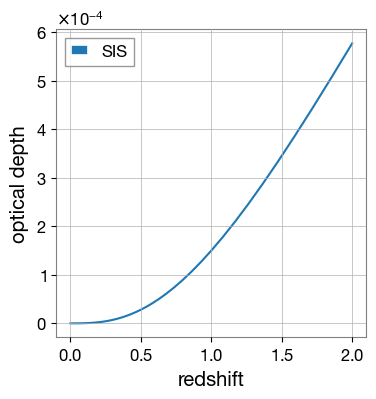

In [145]:
zs = np.geomspace(0.001, 2, 100)
tau_sis = lens.strong_lensing_optical_depth_SIS(zs)

# plot 
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sis, label='SIS')
plt.xlabel('redshift')
plt.ylabel('optical depth')
plt.legend()
plt.show()


## Without jit

In [174]:
from scipy.integrate import quad
from scipy.stats import gengamma


def velocity_dispersion(size):
    a = gengamma.rvs(2.32 / 2.67, 2.67, size=size)
    sigma_ = 161.0 * a

    return sigma_

def cross_section(sigma, zl, zs):
    # find einstein radius
    # Compute the angular diameter distances
    Ds = cosmo.angular_diameter_distance(zs)
    Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
    # Compute the Einstein radii
    theta_E = (
        4.0 * np.pi * (sigma / 299792.458) ** 2 * Dls / (Ds)
    )  # Note: km/s for sigma; Dls, Ds are in Mpc

    sigma = np.pi * theta_E**2
    return sigma

def integrand(zl, zs):
    
    def sigma():
        a = gengamma.rvs(2.32 / 2.67, 2.67, size=500)
        sigma_ = 161.0 * a
        return sigma_

    h = lens.cosmo.H(0).value/100
    no = 8*1e-3* h**3
    test = cross_section(sigma(), zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

def optical_depth_SIS(zs):
    result = quad(integrand, 0, zs, args=(zs))

    return result[0]

In [175]:
%timeit optical_depth_SIS(zs=1)

357 ms ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [188]:
from scipy.integrate import quad
from scipy.stats import gengamma
import numpy as np
from numba import jit
from scipy.interpolate import interp1d

In [206]:
from scipy.interpolate import CubicSpline
import numpy as np

# Example data
x = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
y = np.array([0.0, 0.25, 1.0, 2.25, 4.0])

# Compute the cubic spline interpolation
cs = CubicSpline(x, y)

# Coefficients for cubic spline
coefficients = cs.c.T  # shape is [n, 4], n is the number of intervals

In [218]:
@njit
def cubic_spline_interpolation(x_val, x, coefficients):
    n = len(x)
    
    # Search for the interval x is in, assuming x is sorted
    i = 0
    while i < n - 1:
        if x[i] <= x_val < x[i + 1]:
            break
        i += 1
    
    # When x_val is outside the interval, use boundary points
    i = min(max(i, 0), n - 2)
    dx = x_val - x[i]
    
    # Compute the interpolated value based on the coefficients
    a, b, c, d = coefficients[i]
    interpolated_val = a + b * dx + c * dx ** 2 + d * dx ** 3
    
    return interpolated_val

# Test the JIT-compiled function
x_val = 1.2
result = cubic_spline_interpolation(x_val, x, coefficients)
print(f'Interpolated value at x = {x_val} is {result}')

Interpolated value at x = 1.2 is 0.28799999999999976


In [227]:
z = np.linspace(0.0, 10., 200)  # red-shift
Dc = Planck18.comoving_distance(z).value  # co-moving distance in Mpc
z_to_Dc_coeff = CubicSpline(z, Dc).c.T  # interpolation function

In [230]:
def get_cubic_spline_coefficients(x, y):
    cs = CubicSpline(x, y)
    return cs.c.T  # Transposed to shape [n, 4], where n is the number of intervals

# JIT-compiled function for cubic spline interpolation
@njit
def cubic_spline_interpolation(x_val, x, coefficients):
    n = len(x)
    
    # Search for the interval x is in, assuming x is sorted
    i = 0
    while i < n - 1:
        if x[i] <= x_val < x[i + 1]:
            break
        i += 1
    
    # If x_val is outside the interval, use boundary points
    i = min(max(i, 0), n - 2)
    dx = x_val - x[i]
    
    # Compute the interpolated value using the coefficients
    a, b, c, d = coefficients[i]
    interpolated_val = a + b * dx + c * dx ** 2 + d * dx ** 3
    
    return interpolated_val

# Example usage:

# Original data points
x = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
y = np.array([0.0, 0.25, 1.0, 2.25, 4.0])

# Get cubic spline coefficients
coefficients = get_cubic_spline_coefficients(x, y)

# Use JIT-compiled function for interpolation
x_val = 1.2
result = cubic_spline_interpolation(x_val, x, coefficients)

print(f"Interpolated value at x = {x_val} is {result}")

Interpolated value at x = 1.2 is 0.28799999999999976


In [233]:
# coefficients for cubic spline
z_to_Dc_coeff = get_cubic_spline_coefficients(z, Dc)
x_val = 1.2
result = cubic_spline_interpolation(x_val, z, z_to_Dc_coeff)

In [234]:
result 

141.88511326381936

In [237]:
# coefficients for cubic spline
z_to_Dc = interp1d(x, y, kind="cubic")
x_val = 1.2
z_to_Dc(x_val)

array(1.44)

In [199]:
# Compute Hubble constant in h unit
h = cosmo.H(0).value / 100
# Other constants
no = 8e-3 * h ** 3
c_speed_km_s = 299792.458  # speed of light in km/s
four_pi = 4 * np.pi

class optical_depth():
    def __init__(self, z_max, cosmology=cosmo):
        self.z_max = z_max
        self.cosmo = cosmology
        self.create_lookup_table_lensing(z_max)


    def create_lookup_table_lensing(self, z_max):
        z = np.linspace(0.0, z_max, 500)  # red-shift
        Dc = self.cosmo.comoving_distance(z).value  # co-moving distance in Mpc
        self.z_to_Dc = interp1d(z, Dc, kind="cubic")
        self.Dc_to_z = interp1d(Dc, z, kind="cubic")

        # for angular diameter distance
        quad_ = []  # refers to integration (with quad algorithm) from scipy
        for ii in range(len(z)):
            quad_.append(
                quad(
                    self.cosmo._inv_efunc_scalar,
                    0.0,
                    z[ii],
                    args=self.cosmo._inv_efunc_scalar_args,
                )[0]
            )
        quad_ = np.array(quad_)
        quad_int = interp1d(z, np.array(quad_), kind="cubic")

        H0d = self.cosmo._hubble_distance.value
        self.angular_diameter_distance_z1z2 = (
            lambda zl0, zs0: H0d * (quad_int(zs0) - quad_int(zl0)) / (zs0 + 1.0)
        )
        self.angular_diameter_distance = lambda zs0: H0d * quad_int(zs0) / (zs0 + 1.0)

    @jit(nopython=True)
    def cross_section(self, sigma, Dls_over_Ds):
        theta_E_sq = (4.0 * np.pi * (sigma / c_speed_km_s) ** 2 * Dls_over_Ds)
        return np.pi * theta_E_sq

    @jit(nopython=True)
    def integrand_jit(self, zl, zs, Ds, sigma_array):
        Dls = self.angular_diameter_distance_z1z2(zl, zs)
        Dls_over_Ds = Dls / Ds
        test = cross_section(sigma_array, Dls_over_Ds) * no / four_pi
        return np.mean(test)

    def integrand(self, zl, zs):
        sigma_array = velocity_dispersion(500)  # Generating a fixed-size array
        Ds = self.angular_diameter_distance(zs).value  # value in Mpc
        return integrand_jit(zl, zs, Ds, sigma_array)

    def velocity_dispersion(self, size):
        a = gengamma.rvs(2.32 / 2.67, 2.67, size=size)
        sigma_ = 161.0 * a
        return sigma_

    def optical_depth_SIS(self, zs):
        result, _ = quad(integrand, 0, zs, args=(zs))
        return result

In [200]:
test = optical_depth(z_max=40, cosmology=cosmo)

ValueError: unable to broadcast argument 3 to output array
File "/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/numba/np/npyimpl.py", line 227, 

In [195]:
test.optical_depth_SIS(2)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'cosmo': Cannot determine Numba type of <class 'astropy.cosmology.flrw.lambdacdm.FlatLambdaCDM'>

File "../../../../../../../var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_26504/2777305077.py", line 22:
<source missing, REPL/exec in use?>


In [149]:
def strong_lensing_optical_depth_SIS(zs):
    # For SIS model
    # z to luminosity_distance (luminosity_distance) conversion
    Dc = cosmo.comoving_distance(zs).value * 1e-3  # 1e-3 converts Mpc to Gpc

    return 4.17*1e-6*(Dc) ** 3

strong_lensing_optical_depth_SIS(zs=1)

0.00015037950859109853

In [150]:
zs = np.geomspace(0.001, 40, 100)
# Haris
tau_sis1 = strong_lensing_optical_depth_SIS(zs)

In [151]:
# planck18
tau_sis2 = np.array([optical_depth_SIS(zs=z) for z in zs])

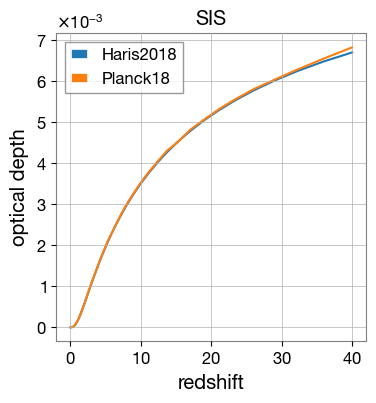

In [152]:
# plot 
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sis1, label='Haris2018')
plt.plot(zs, tau_sis2, label='Planck18')
plt.xlabel('redshift')
plt.ylabel('optical depth')
plt.title('SIS')
plt.legend()
plt.show()

In [153]:
zs = np.geomspace(0.001, 5, 100)
# Haris
tau_sis1 = strong_lensing_optical_depth_SIS(zs)
# planck18
tau_sis2 = np.array([optical_depth_SIS(zs=z) for z in zs])

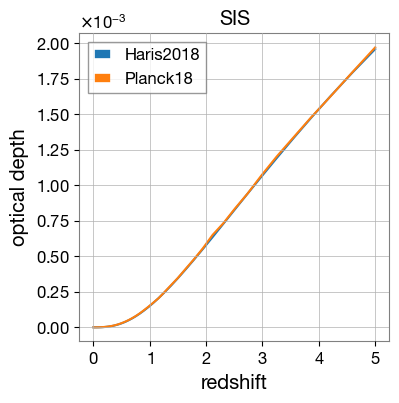

In [154]:
# plot 
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sis1, label='Haris2018')
plt.plot(zs, tau_sis2, label='Planck18')
plt.xlabel('redshift')
plt.ylabel('optical depth')
plt.title('SIS')
plt.legend()
plt.show()

In [ ]:
# import gamma function
from scipy.special import gamma

def integrand2(zl, zs):

    test = 16*np.pi**3*(1+zl)**2*c*n/H(zl)